# AMACOR DEPOSITOS PLAZO FIJO

### DEFINICIÓN PROYECTOS

-Realizar un análisis exploratorio detallado sobre los diferentes tipos de 
clientes presentes en el conjunto de datos. 


-Desarrollar un modelo predictivo para identificar qué clientes tienen más 
probabilidad de contratar un depósito a plazo fijo. 


-Explicar los resultados obtenidos y proporcionar recomendaciones para 
mejorar la eficacia de futuras campañas.

### Importamos librerias

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering as AC
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error


### Importamos Dataframe y creamos una copia para modificar la data

In [231]:
#original es la base de datos SIN tocar
original = pd.read_csv('Sesión #80_ML_Caso Práctico_3_Data_Train.csv',sep= ";")
#Vamos a trabajar con df
df = original.copy()
df_model_no_viewed_data_og= pd.read_csv('Sesión #80_ML_Caso Práctico_3_Data_Test.csv',sep=";")


In [232]:
df['trabajo'].value_counts()

trabajo
blue-collar      9519
management       9263
technician       7436
admin.           5076
services         4056
retired          2217
self-employed    1548
entrepreneur     1450
unemployed       1274
housemaid        1215
student           922
unknown           280
Name: count, dtype: int64

### Exploratory Data Analysis

In [233]:
total_data_original = original.shape[0]
print(f"Hay {total_data_original} filas y {original.shape[1]} columnas en el dataframe")
print(f"{df.columns}")

Hay 44256 filas y 17 columnas en el dataframe
Index(['ID', 'edad', 'trabajo', 'estado_civil', 'educacion', 'deuda', 'saldo',
       'vivienda', 'prestamo', 'tipo_contacto', 'duracion', 'fecha_contacto',
       'campaign', 'tiempo_transcurrido', 'contactos_anteriores',
       'resultado_campanas_anteriores', 'target'],
      dtype='object')


In [234]:
print(f"Hay un total de {df.duplicated().sum()} duplicados")
print(f"Hay un total de {df.isnull().sum().sum()} valores nulos")
df.isnull().sum()
df['tipo_contacto'].fillna('Sin especificar', inplace=True)
df['resultado_campanas_anteriores'].fillna('Sin especificar', inplace=True)
df.dropna(inplace=True)
print("\nDespues de eliminar los nulos, las columnas quedan así:")
df.isnull().sum()

Hay un total de 0 duplicados
Hay un total de 50703 valores nulos

Despues de eliminar los nulos, las columnas quedan así:


ID                               0
edad                             0
trabajo                          0
estado_civil                     0
educacion                        0
deuda                            0
saldo                            0
vivienda                         0
prestamo                         0
tipo_contacto                    0
duracion                         0
fecha_contacto                   0
campaign                         0
tiempo_transcurrido              0
contactos_anteriores             0
resultado_campanas_anteriores    0
target                           0
dtype: int64

In [235]:
df.shape

(42446, 17)

### Cluster DF Normal

In [236]:
df_cluster = df.drop(columns=['ID','fecha_contacto','campaign','tiempo_transcurrido','contactos_anteriores','target','duracion'],inplace=False)
df_cluster_procesado = df_cluster.copy()

In [237]:
# Tu código
# Creamos el objeto que realizará la transformación

#Instancio el OneHot
onehot=OneHotEncoder()

# Aplico el OneHot a la columna job y guardo el resultado en a
onehot.fit(df_cluster_procesado[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"]])
a=onehot.transform(df_cluster_procesado[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"]])

# Convierto el a en data frame y lo llamo encoded_df
encoded_df = pd.DataFrame(a.toarray(), columns=onehot.get_feature_names_out(["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"]))

# Reseteo el índice de los dos data frames antes de concatenarlos
df_cluster_procesado.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# concateno los dos data frames y los guardo machacando el df
df_cluster_procesado=pd.concat([df_cluster_procesado,encoded_df],axis=1)

# Elimino la columna Job original antigua, la categórica
df_cluster_procesado.drop(columns=["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"],inplace=True)

# Muestro tamaño yu sample del data frame df transformado
print(df_cluster_procesado.shape)
df_cluster_procesado.sample(5)

(42446, 31)


,edad,educacion,saldo,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,...,deuda_no,deuda_si,vivienda_no,vivienda_si,prestamo_no,prestamo_si,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito
8220,41,secundaria/superiores,306,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
41600,43,secundaria/superiores,1335,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
5719,37,universitarios,5122,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
27687,50,universitarios,830,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
27121,41,secundaria/superiores,112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [238]:
ordinal = OrdinalEncoder(categories=[['priamaria', 'secundaria/superiores', 'universitarios']])
aux = ordinal.fit_transform(df_cluster_procesado['educacion'].values.reshape(-1, 1))
df_cluster_procesado['educacion_codificado'] = aux
df_cluster_procesado.drop(columns='educacion',inplace=True)

In [239]:
df_cluster_procesado

,edad,saldo,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,trabajo_services,...,deuda_si,vivienda_no,vivienda_si,prestamo_no,prestamo_si,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito,educacion_codificado
0,40,580,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,47,3644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,25,538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0
3,42,1773,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0
4,56,217,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42441,38,-323,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
42442,49,1982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
42443,51,794,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
42444,29,98,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0


In [240]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_cluster_procesado[['edad']].values.reshape(-1, 1))
df_cluster_procesado['edad_codificada'] = aux
df_cluster_procesado.drop(columns='edad',inplace=True)

In [241]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_cluster_procesado[['saldo']].values.reshape(-1, 1))
df_cluster_procesado['saldo_codificado'] = aux
df_cluster_procesado.drop(columns='saldo',inplace=True)

In [242]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

In [243]:
mi_cluster = AC(n_clusters=3,linkage='ward',compute_distances=True)
mi_cluster.fit(df_cluster_procesado)

AgglomerativeClustering(compute_distances=True, n_clusters=3)

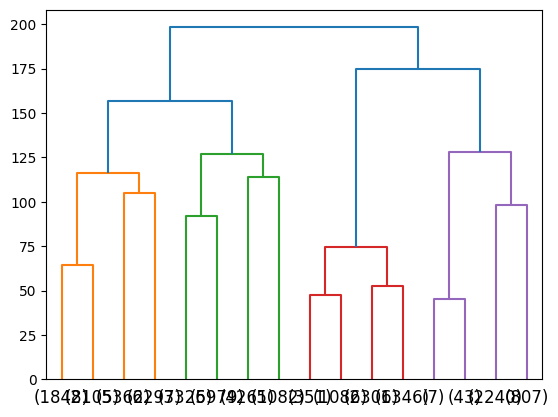

In [244]:
plot_dendrogram(mi_cluster, truncate_mode='level',p=3)

In [245]:
mi_cluster = AC(n_clusters=5,linkage='ward',compute_distances=True)
# Haz un fit y predict para qwue nos devuelva los grupos que los guardamos en la variable grupos
grupos = mi_cluster.fit_predict(df_cluster_procesado)
# Crea una nueva variable en el data frame original df con el número de grupo que te acabas de guardar y muestra un sample de df
df['clusters'] = grupos
df_cluster['clusters'] = grupos

### Cluster para df datos no vistos

In [246]:
print(f"Hay un total de {df_model_no_viewed_data_og.duplicated().sum()} duplicados")
print(f"Hay un total de {df_model_no_viewed_data_og.isnull().sum().sum()} valores nulos")
df_model_no_viewed_data_og.isnull().sum()
df_model_no_viewed_data_og['tipo_contacto'].fillna('Sin especificar', inplace=True)
df_model_no_viewed_data_og['resultado_campanas_anteriores'].fillna('Sin especificar', inplace=True)
df_model_no_viewed_data_og.dropna(inplace=True)
print("\nDespues de eliminar los nulos, las columnas quedan así:")
df_model_no_viewed_data_og.isnull().sum()


Hay un total de 0 duplicados
Hay un total de 5136 valores nulos

Despues de eliminar los nulos, las columnas quedan así:


ID                               0
edad                             0
trabajo                          0
estado_civil                     0
educacion                        0
deuda                            0
saldo                            0
vivienda                         0
prestamo                         0
tipo_contacto                    0
duracion                         0
fecha_contacto                   0
campaign                         0
tiempo_transcurrido              0
contactos_anteriores             0
resultado_campanas_anteriores    0
target                           0
dtype: int64

In [247]:
df_model_no_viewed_data_cluster = df_model_no_viewed_data_og.copy()
df_model_no_viewed_data_cluster = df_model_no_viewed_data_cluster.drop(columns=['ID','fecha_contacto','campaign','tiempo_transcurrido','contactos_anteriores','target','duracion'],inplace=False)

In [248]:
# Tu código
# Creamos el objeto que realizará la transformación

#Instancio el OneHot
onehot=OneHotEncoder()

# Aplico el OneHot a la columna job y guardo el resultado en a
onehot.fit(df_model_no_viewed_data_cluster[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"]])
a=onehot.transform(df_model_no_viewed_data_cluster[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"]])

# Convierto el a en data frame y lo llamo encoded_df
encoded_df = pd.DataFrame(a.toarray(), columns=onehot.get_feature_names_out(["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"]))

# Reseteo el índice de los dos data frames antes de concatenarlos
df_model_no_viewed_data_cluster.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# concateno los dos data frames y los guardo machacando el df
df_model_no_viewed_data_cluster=pd.concat([df_model_no_viewed_data_cluster,encoded_df],axis=1)

# Elimino la columna Job original antigua, la categórica
df_model_no_viewed_data_cluster.drop(columns=["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","resultado_campanas_anteriores"],inplace=True)

# Muestro tamaño yu sample del data frame df transformado
print(df_model_no_viewed_data_cluster.shape)
df_model_no_viewed_data_cluster.sample(5)

(4255, 31)


,edad,educacion,saldo,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,...,deuda_no,deuda_si,vivienda_no,vivienda_si,prestamo_no,prestamo_si,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito
3315,30,secundaria/superiores,239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1994,43,secundaria/superiores,104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2906,28,secundaria/superiores,517,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1430,49,priamria,305,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
305,41,secundaria/superiores,-41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [249]:
ordinal = OrdinalEncoder(categories=[['priamria', 'secundaria/superiores', 'universitarios']])
aux = ordinal.fit_transform(df_model_no_viewed_data_cluster['educacion'].values.reshape(-1, 1))
df_model_no_viewed_data_cluster['educacion_codificado'] = aux
df_model_no_viewed_data_cluster.drop(columns='educacion',inplace=True)

In [250]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_model_no_viewed_data_cluster[['edad']].values.reshape(-1, 1))
df_model_no_viewed_data_cluster['edad_codificada'] = aux
df_model_no_viewed_data_cluster.drop(columns='edad',inplace=True)

In [251]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_model_no_viewed_data_cluster[['saldo']].values.reshape(-1, 1))
df_model_no_viewed_data_cluster['saldo_codificado'] = aux
df_model_no_viewed_data_cluster.drop(columns='saldo',inplace=True)

In [252]:
df_model_no_viewed_data_cluster

,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,trabajo_services,trabajo_student,trabajo_technician,...,vivienda_si,prestamo_no,prestamo_si,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito,educacion_codificado,edad_codificada,saldo_codificado
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.961114,-1.163251
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0.865586,0.496433
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.865586,0.005183
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.376273,-0.467006
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.949439,-0.213857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,-0.662856,-0.135270
4251,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.376273,-0.467006
4252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.662856,-0.151656
4253,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.961114,-0.027255


In [253]:
mi_cluster = AC(n_clusters=5,linkage='ward',compute_distances=True)
# Haz un fit y predict para qwue nos devuelva los grupos que los guardamos en la variable grupos
grupos = mi_cluster.fit_predict(df_model_no_viewed_data_cluster)
df_model_no_viewed_data_og['clusters']=grupos

### Identificamos categoricas y numericas

In [254]:
def ident_cat_num(df): 
    # ESTA FUNCION IDENTIFICA SI LOS DATOS SON DE TIPO NUMERICO O CATEGORICO
    import pandas as pd
    #CREAMOS UNA LISTA PARA DESPUÉS ALMACENAR LOS NOMBRES DE LAS COLUMNAS QUE SEAN NUMERICAS
    list_numericas = [] 
    #CREAMOS UNA LISTA PARA DESPUÉS ALMACENAR LOS NOMBRES DE LAS COLUMNAS QUE SEAN CATEGORICAS
    list_categoricas = []
    #RECORREMOS LAS COLUMNAS DE LA BASE DE DATOS
    for i in df.columns: 
        #IDENTIFICAMOS SI LOS DATOS QUE CONTIENE LA COLUMNA SON NUMERICOS
        if pd.api.types.is_numeric_dtype(df[i])== True:
            #ALMACENAMOS LOS NOMBRES DE LAS COLUMNAS QUE SEAN NUM
            list_numericas.append(i)
        else:
            #SINO LOS ALMACENAMOS LOS NOMBRES DE LAS COLUMNAS QUE SEAN CATEGORICAS
            list_categoricas.append(i)
    return list_numericas,list_categoricas
lista_numericas=ident_cat_num(df_cluster)[0]
lista_categoricas=ident_cat_num(df_cluster)[1]

In [255]:
df_cluster[lista_numericas].groupby(['clusters']).mean()

,edad,saldo
clusters,,
0,41.430448,651.052606
1,35.346016,749.694786
2,54.847711,1476.441934
3,40.995077,7793.328848
4,50.600000,47065.800000


In [256]:
df_cluster[lista_numericas].groupby(['clusters']).std()

,edad,saldo
clusters,,
0,8.977002,972.829069
1,7.887236,1104.495101
2,9.593742,2002.888293
3,9.480687,5042.509006
4,12.280730,16799.118873


### Creación del modelo predictivo
 

#### Parte I: Creamos y entrenamos modelo


In [440]:
df_model_train = df.drop(columns=['ID','fecha_contacto','campaign','tiempo_transcurrido','contactos_anteriores','duracion'],inplace=False)
df['clusters']=df['clusters'].astype(object)

In [441]:
# Tu código
# Creamos el objeto que realizará la transformación

#Instancio el OneHot
onehot=OneHotEncoder()

# Aplico el OneHot a la columna job y guardo el resultado en a
onehot.fit(df_model_train[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"]])
a=onehot.transform(df_model_train[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"]])

# Convierto el a en data frame y lo llamo encoded_df
encoded_df = pd.DataFrame(a.toarray(), columns=onehot.get_feature_names_out(["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"]))

# Reseteo el índice de los dos data frames antes de concatenarlos
df_model_train.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# concateno los dos data frames y los guardo machacando el df
df_model_train=pd.concat([df_model_train,encoded_df],axis=1)

# Elimino la columna Job original antigua, la categórica
df_model_train.drop(columns=["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"],inplace=True)

# Muestro tamaño yu sample del data frame df transformado
print(df_model_train.shape)
df_model_train.sample(5)

(42446, 37)


,edad,educacion,saldo,target,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,...,prestamo_si,clusters_0,clusters_1,clusters_2,clusters_3,clusters_4,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito
14553,54,universitarios,345,no,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
25609,47,secundaria/superiores,177,no,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
28026,43,priamaria,0,no,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
26682,59,secundaria/superiores,0,no,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
39722,49,secundaria/superiores,0,no,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [442]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_model_train[['edad']].values.reshape(-1, 1))
df_model_train['edad_codificada'] = aux
df_model_train.drop(columns='edad',inplace=True)

In [443]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_model_train[['saldo']].values.reshape(-1, 1))
df_model_train['saldo_codificadao'] = aux
df_model_train.drop(columns='saldo',inplace=True)

In [444]:
ordinal = OrdinalEncoder(categories=[['priamaria', 'secundaria/superiores', 'universitarios']])
aux = ordinal.fit_transform(df_model_train['educacion'].values.reshape(-1, 1))
df_model_train['educacion_codificado'] = aux
df_model_train.drop(columns='educacion',inplace=True)

In [445]:
df_model_train['target'] = df_model_train['target'].map({'no': 0, 'si': 1})

In [446]:
X = df_model_train.drop(['target'],axis=1,inplace=False)
y = df_model_train['target']

In [447]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [448]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

modelo = KNeighborsClassifier(n_neighbors=7, weights='distance',p=2,algorithm = 'auto')
modelo.fit(X_train, y_train)

# Utilizar predict_proba para obtener probabilidades
probabilidades = modelo.predict_proba(X_test)
predicciones = modelo.predict(X_test)
probabilidades_df_model_train=modelo.predict_proba(X).round(2)
df_model_train[['no','si']]=probabilidades_df_model_train


In [487]:
df_model_train[df_model_train['si'] > 0.60].sample(10)

,target,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,trabajo_services,trabajo_student,...,clusters_4,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito,edad_codificada,saldo_codificadao,educacion_codificado,no,si
17021,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.115817,-0.324099,1.0,0.00,1.00
14848,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,-1.309015,0.159583,2.0,0.00,1.00
13499,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.359127,0.204866,1.0,0.00,1.00
8090,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-1.119037,-0.071758,1.0,0.00,1.00
41320,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.739082,-0.333944,1.0,0.00,1.00
3296,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.255682,0.092642,1.0,0.00,1.00
39294,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,-1.688970,-0.302770,1.0,0.00,1.00
19554,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-1.404004,0.029966,1.0,0.00,1.00
21402,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.739082,-0.402526,2.0,0.00,1.00
14229,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,-1.024049,2.021136,2.0,0.03,0.97


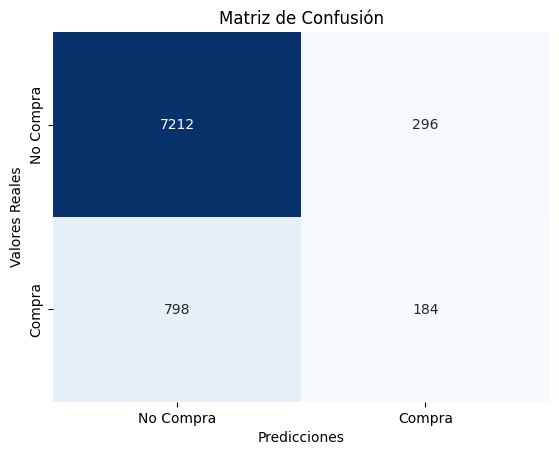

In [451]:
matriz_confusion = confusion_matrix(y_test, predicciones)

# Crear un mapa de calor con seaborn
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Compra', 'Compra'], yticklabels=['No Compra', 'Compra'])

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

### Parte II: Probamos modelo con datos nuevos 

In [452]:
#Leemos los nuevos datos que el modelo NO ha visto
df_model_no_viewed_data = df_model_no_viewed_data_og.copy()

In [453]:
df_model_no_viewed_data = df_model_no_viewed_data.drop(columns=['ID','fecha_contacto','campaign','tiempo_transcurrido','contactos_anteriores','duracion','target'],inplace=False)


In [454]:
df_model_no_viewed_data_og.shape

(4255, 18)

In [455]:
# Tu código
# Creamos el objeto que realizará la transformación

#Instancio el OneHot
onehot=OneHotEncoder()

# Aplico el OneHot a la columna job y guardo el resultado en a
onehot.fit(df_model_no_viewed_data[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"]])
a=onehot.transform(df_model_no_viewed_data[["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"]])

# Convierto el a en data frame y lo llamo encoded_df
encoded_df = pd.DataFrame(a.toarray(), columns=onehot.get_feature_names_out(["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"]))

# Reseteo el índice de los dos data frames antes de concatenarlos
df_model_no_viewed_data.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

# concateno los dos data frames y los guardo machacando el df
df_model_no_viewed_data=pd.concat([df_model_no_viewed_data,encoded_df],axis=1)

# Elimino la columna Job original antigua, la categórica
df_model_no_viewed_data.drop(columns=["trabajo","tipo_contacto","estado_civil","deuda","vivienda","prestamo","clusters","resultado_campanas_anteriores"],inplace=True)

# Muestro tamaño yu sample del data frame df transformado
print(df_model_no_viewed_data.shape)
df_model_no_viewed_data.sample(5)

(4255, 36)


,edad,educacion,saldo,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,...,prestamo_si,clusters_0,clusters_1,clusters_2,clusters_3,clusters_4,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito
950,46,universitarios,1297,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1255,46,universitarios,273,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
844,38,universitarios,8669,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1735,57,secundaria/superiores,158,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1399,34,secundaria/superiores,341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [456]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_model_no_viewed_data[['edad']].values.reshape(-1, 1))
df_model_no_viewed_data['edad_codificada'] = aux
df_model_no_viewed_data.drop(columns='edad',inplace=True)

In [457]:
escalador = StandardScaler()
aux = escalador.fit_transform(df_model_no_viewed_data[['saldo']].values.reshape(-1, 1))
df_model_no_viewed_data['saldo_codificadao'] = aux
df_model_no_viewed_data.drop(columns='saldo',inplace=True)

In [458]:
ordinal = OrdinalEncoder(categories=[['priamria', 'secundaria/superiores', 'universitarios']])
aux = ordinal.fit_transform(df_model_no_viewed_data['educacion'].values.reshape(-1, 1))
df_model_no_viewed_data['educacion_codificado'] = aux
df_model_no_viewed_data.drop(columns='educacion',inplace=True)

In [459]:
mi_cluster = AC(n_clusters=5,linkage='ward',compute_distances=True)
# Haz un fit y predict para qwue nos devuelva los grupos que los guardamos en la variable grupos
grupos = mi_cluster.fit_predict(df_model_no_viewed_data)
df_model_no_viewed_data['clusters'] = grupos
df_model_no_viewed_data.drop(columns='clusters',inplace=True)

In [460]:
df_model_no_viewed_data[['porcentaje_no','porcentaje_si']] = modelo.predict_proba(df_model_no_viewed_data).round(2)


In [488]:
df_model_no_viewed_data.sample(10)

,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,trabajo_services,trabajo_student,trabajo_technician,...,clusters_4,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito,edad_codificada,saldo_codificadao,educacion_codificado,porcentaje_no,porcentaje_si
120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.343224,-0.404806,1.0,1.00,0.00
1182,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-1.236022,-0.482389,1.0,0.29,0.71
2423,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.662856,0.636886,2.0,0.43,0.57
2060,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,-0.376273,-0.284083,2.0,0.86,0.14
1321,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.865586,-0.470350,0.0,1.00,0.00
2205,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.005837,-0.209175,2.0,0.71,0.29
2296,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,-0.853912,-0.149984,2.0,1.00,0.00
2503,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.011918,-0.194127,1.0,0.86,0.14
3928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,-0.758384,-0.347287,1.0,1.00,0.00
2623,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.483475,-0.443598,1.0,0.86,0.14


In [462]:
df_model_no_viewed_data[df_model_no_viewed_data['porcentaje_si']> 0.60]

,trabajo_admin.,trabajo_blue-collar,trabajo_entrepreneur,trabajo_housemaid,trabajo_management,trabajo_retired,trabajo_self-employed,trabajo_services,trabajo_student,trabajo_technician,...,clusters_4,resultado_campanas_anteriores_Sin especificar,resultado_campanas_anteriores_exito,resultado_campanas_anteriores_otro,resultado_campanas_anteriores_sin_exito,edad_codificada,saldo_codificadao,educacion_codificado,porcentaje_no,porcentaje_si
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,-1.140495,-0.429218,1.0,0.00,1.00
35,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,3.253778,0.794059,1.0,0.01,0.99
41,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,-0.662856,-0.107180,1.0,0.14,0.86
129,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.438752,-0.117881,1.0,0.37,0.63
145,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,3.062722,-0.373706,0.0,0.36,0.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3971,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.629807,-0.312508,1.0,0.05,0.95
4096,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.674531,-0.083436,2.0,0.29,0.71
4162,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.967195,-0.211850,0.0,0.30,0.70
4200,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,2.202973,-0.184094,2.0,0.17,0.83


### Exploración de la base de datos

In [463]:
#Miramos cuantas personas sin contacto tiene mas de x dinero (en este caso 1000)
df_sin_contacto =df[df['tipo_contacto'] == 'Sin especificar']
saldo = 1000
num =df_sin_contacto[df_sin_contacto['saldo'] >= saldo]
df_sin_contacto_prct= (num.shape[0]/ (df_sin_contacto.shape[0])) * 100
df_sin_contacto_prct = int(df_sin_contacto_prct)
print(f"Tenemos un {(df_sin_contacto_prct)}% de clientes con mas de {saldo}€ sin contacto ")

Tenemos un 29% de clientes con mas de 1000€ sin contacto 


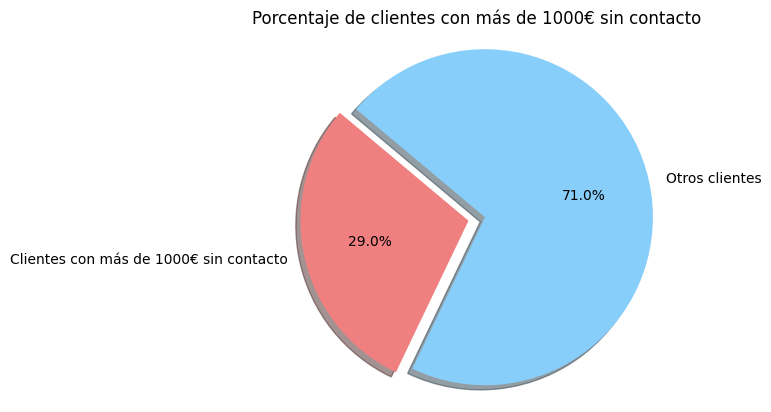

In [464]:
labels = [f"Clientes con más de {saldo}€ sin contacto", "Otros clientes"]
sizes = [df_sin_contacto_prct, 100 - df_sin_contacto_prct]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

# Crear el gráfico de barras
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Porcentaje de clientes con más de {saldo}€ sin contacto")
plt.show()

#### Personas con más dinero

In [465]:
personas_con_mas_de = (df[df['saldo']>25000])
print(f"Hay un total de {personas_con_mas_de.shape[0]} personas con mas de 25.000€")

Hay un total de 95 personas con mas de 25.000€


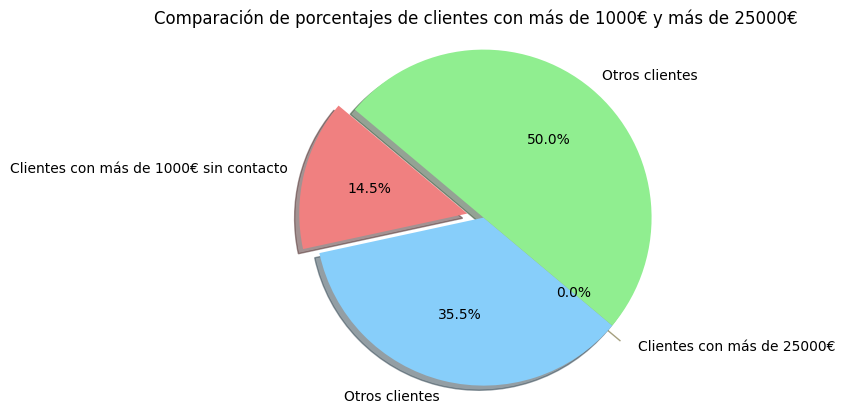

In [466]:
#GRAFICO
personas_con_mas_de = df[df['saldo'] > 25000]
porcentaje_personas_con_mas_de = (personas_con_mas_de.shape[0] / df.shape[0]) * 100
porcentaje_personas_con_mas_de = int(porcentaje_personas_con_mas_de)

# Crear gráfico combinado
labels_combined = [f"Clientes con más de {saldo}€ sin contacto", "Otros clientes",
                   f"Clientes con más de {25000}€", "Otros clientes"]
sizes_combined = [df_sin_contacto_prct, 100 - df_sin_contacto_prct,
                  porcentaje_personas_con_mas_de, 100 - porcentaje_personas_con_mas_de]
colors_combined = ['lightcoral', 'lightskyblue', 'gold', 'lightgreen']
explode_combined = (0.1, 0, 0.1, 0)

# Crear el gráfico de barras combinado
plt.pie(sizes_combined, explode=explode_combined, labels=labels_combined, colors=colors_combined, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title(f"Comparación de porcentajes de clientes con más de {saldo}€ y más de 25000€")
plt.show()

In [467]:
print(personas_con_mas_de['deuda'].value_counts())
print(f"Vemos que el 100% de las personas con 25.000€ no tienen deuda")

deuda
no    95
Name: count, dtype: int64
Vemos que el 100% de las personas con 25.000€ no tienen deuda


#### Personas con vivienda en propiedad

In [468]:
df_vivienda_si =df[df['vivienda'] == 'si']
num_persona_con_vivienda =df[df['vivienda'] == 'si'].shape[0]
num_persona_con_vivienda = int(num_persona_con_vivienda)
num_persona_con_vivienda_prct = int(((num_persona_con_vivienda) / df.shape[0])*100)

In [469]:
print(f"En la base de datos, hay un total de {num_persona_con_vivienda_prct}% de clientes con vivienda")
total_personas=df['vivienda'].value_counts().sum()

En la base de datos, hay un total de 56% de clientes con vivienda


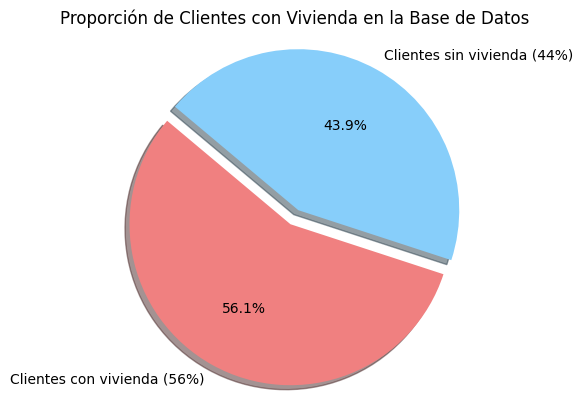

In [470]:
#GRAFICO
# Crear gráfico de pastel
labels = [f"Clientes con vivienda ({num_persona_con_vivienda_prct}%)", f"Clientes sin vivienda ({100 - num_persona_con_vivienda_prct}%)"]
sizes = [num_persona_con_vivienda, total_personas - num_persona_con_vivienda]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Proporción de Clientes con Vivienda en la Base de Datos')
plt.show()

In [471]:
df_vivienda_propia_con_deuda = df_vivienda_si[df_vivienda_si['deuda'] == 'si']
#df_vivienda_propia_con_deuda[df_vivienda_propia_con_deuda['edad']==71]

In [472]:
df_vivienda_si_sin_deuda=df_vivienda_si[df_vivienda_si[['deuda','prestamo']] == 'no']

In [473]:
personas_sin_deuda_y_con_vivienda_sin_prestamo = df[(df['deuda'] == 'no') & (df['vivienda'] == 'si') & (df['prestamo'] == 'no')]

# Contar el número de personas que cumplen con las condiciones
num_personas = len(personas_sin_deuda_y_con_vivienda_sin_prestamo)

# Mostrar la cantidad de personas en un DataFrame
dataframe_personas = personas_sin_deuda_y_con_vivienda_sin_prestamo.reset_index(drop=True)  # Reiniciar el índice
print("Cantidad de personas: ", num_personas)
print("\nDataFrame con las personas:")
dataframe_personas

Cantidad de personas:  19320

DataFrame con las personas:


,ID,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,tipo_contacto,duracion,fecha_contacto,campaign,tiempo_transcurrido,contactos_anteriores,resultado_campanas_anteriores,target,clusters
0,1,40,blue-collar,casado,secundaria/superiores,no,580,si,no,Sin especificar,192,16-may-2021,1,-1,0,Sin especificar,no,0
1,3,25,student,soltero,universitarios,no,538,si,no,movil,226,20-apr-2021,1,-1,0,Sin especificar,no,1
2,9,30,blue-collar,soltero,secundaria/superiores,no,3,si,no,movil,51,25-jul-2021,1,-1,0,Sin especificar,no,1
3,12,48,blue-collar,divorciado,secundaria/superiores,no,65,si,no,movil,146,14-may-2021,1,370,1,sin_exito,no,0
4,14,31,management,divorciado,universitarios,no,883,si,no,movil,112,5-mar-2021,2,106,1,sin_exito,si,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19315,44247,29,services,soltero,secundaria/superiores,no,498,si,no,Sin especificar,177,3-jun-2021,26,-1,0,Sin especificar,no,1
19316,44249,30,blue-collar,casado,priamaria,no,597,si,no,Sin especificar,190,23-may-2021,1,-1,0,Sin especificar,no,0
19317,44252,38,management,casado,secundaria/superiores,no,-323,si,no,Sin especificar,250,9-jun-2021,1,-1,0,Sin especificar,no,0
19318,44254,51,blue-collar,casado,secundaria/superiores,no,794,si,no,fijo,747,24-jul-2021,1,-1,0,Sin especificar,no,0


#### Personas sin deuda con vivienda en propiedad sin presatamo y sin contacto

In [474]:
personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono=personas_sin_deuda_y_con_vivienda_sin_prestamo['tipo_contacto'].isnull().sum()
personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono_prct=int((personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono / personas_sin_deuda_y_con_vivienda_sin_prestamo.shape[0])* 100)
print(f"En la base de datos, hay un total de {personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono_prct}% de personas sin contacto y con vivienda en propiedad sin prestamo y sin telefono")

En la base de datos, hay un total de 0% de personas sin contacto y con vivienda en propiedad sin prestamo y sin telefono


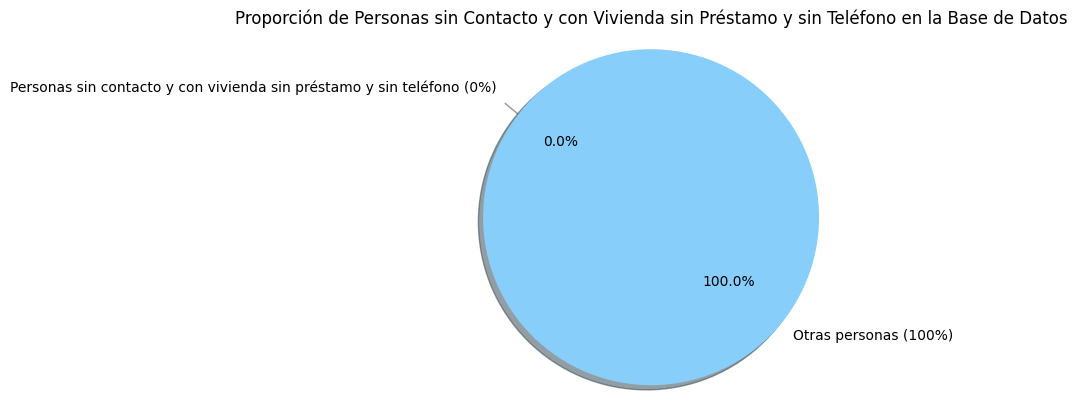

In [475]:
#GRAFICO
# Crear gráfico de pastel
labels = [f"Personas sin contacto y con vivienda sin préstamo y sin teléfono ({personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono_prct}%)",
          f"Otras personas ({100 - personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono_prct}%)"]
sizes = [personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono, personas_sin_deuda_y_con_vivienda_sin_prestamo.shape[0] - personas_sin_deuda_y_con_vivienda_sin_prestamo_sin_telefono]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

# Crear el gráfico de pastel
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Proporción de Personas sin Contacto y con Vivienda sin Préstamo y sin Teléfono en la Base de Datos')
plt.show()

#### Personas con estado civil 'casados' 

In [476]:
#Se miran las personas que están casadas ya que al ser dos personas en la unidad familiar es más facil destinar x dinero al mes
df_personas_casadas = df[df['estado_civil'] == 'casado']
#Se puede obsevar  que contra mas saldo hay, la probabilidad de que tenga vivienda es más alta
# Tambien se puede apreciar que la media de edad sube
total_personas_casadas = df_personas_casadas.shape[0]


In [477]:
#Personas con estado civil 'casados' con más saldo
saldo = 5000
df_personas_casadas_con_mas_saldo=df_personas_casadas[df_personas_casadas['saldo'] > saldo]
print(f"Hay un total de {df_personas_casadas_con_mas_saldo.shape[0]} personas casadas con mas de {saldo}€.")
porcentaje_personas_casadas_con_mas_saldo = (df_personas_casadas_con_mas_saldo.shape[0] / total_personas_casadas) * 100

Hay un total de 1688 personas casadas con mas de 5000€.


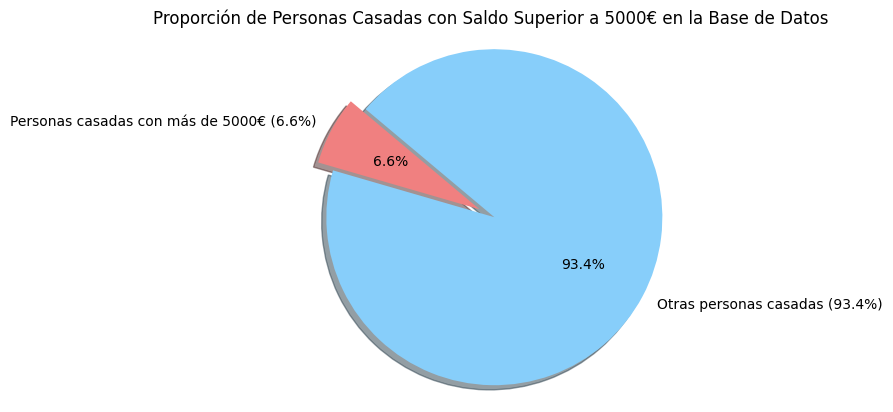

In [478]:
#GRAFICO
# Crear gráfico de pastel
labels = [f"Personas casadas con más de {saldo}€ ({porcentaje_personas_casadas_con_mas_saldo:.1f}%)",
          f"Otras personas casadas ({100 - porcentaje_personas_casadas_con_mas_saldo:.1f}%)"]
sizes = [df_personas_casadas_con_mas_saldo.shape[0], total_personas_casadas - df_personas_casadas_con_mas_saldo.shape[0]]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

# Crear el gráfico de pastel
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title(f'Proporción de Personas Casadas con Saldo Superior a {saldo}€ en la Base de Datos')
plt.show()

In [479]:
#Personas con estado civil 'casados' con más saldo con vivienda
df_personas_casadas_con_mas_saldo_con_vivienda=df_personas_casadas_con_mas_saldo[df_personas_casadas_con_mas_saldo['vivienda'] == 'si']
print(f"Hay un total de {df_personas_casadas_con_mas_saldo_con_vivienda.shape[0]} personas casadas con más de {saldo}€ y que tienen vivienda propia" )
porcentaje_personas_casadas_con_mas_saldo_con_vivienda = (df_personas_casadas_con_mas_saldo_con_vivienda.shape[0] / total_personas_casadas) * 100


Hay un total de 781 personas casadas con más de 5000€ y que tienen vivienda propia


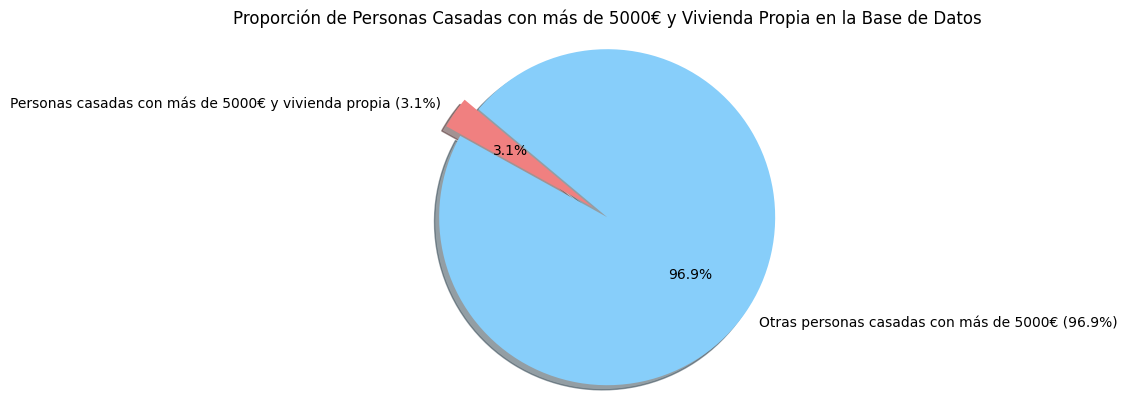

In [480]:
#GRAFICO
# Crear gráfico de pastel
labels = [f"Personas casadas con más de {saldo}€ y vivienda propia ({porcentaje_personas_casadas_con_mas_saldo_con_vivienda:.1f}%)",
          f"Otras personas casadas con más de {saldo}€ ({100 - porcentaje_personas_casadas_con_mas_saldo_con_vivienda:.1f}%)"]
sizes = [df_personas_casadas_con_mas_saldo_con_vivienda.shape[0], total_personas_casadas - df_personas_casadas_con_mas_saldo_con_vivienda.shape[0]]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

# Crear el gráfico de pastel
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title(f'Proporción de Personas Casadas con más de {saldo}€ y Vivienda Propia en la Base de Datos')
plt.show()

In [481]:
df_personas_casadas_con_mas_saldo_con_vivienda_con_contacto = df_personas_casadas_con_mas_saldo_con_vivienda[df_personas_casadas_con_mas_saldo_con_vivienda['tipo_contacto'] == 'movil' ]
print(f"Hay un total de {df_personas_casadas_con_mas_saldo_con_vivienda_con_contacto.shape[0]} personas casadas con más de {saldo}€ y que tienen vivienda propia y tenemos el contacto" )

Hay un total de 498 personas casadas con más de 5000€ y que tienen vivienda propia y tenemos el contacto


In [482]:
#GRAFICO


#### PRUEBAS

In [483]:
pd.DataFrame(df_personas_casadas_con_mas_saldo_con_vivienda_con_contacto[df_personas_casadas_con_mas_saldo_con_vivienda_con_contacto['target'] == 'no'])

,ID,edad,trabajo,estado_civil,educacion,deuda,saldo,vivienda,prestamo,tipo_contacto,duracion,fecha_contacto,campaign,tiempo_transcurrido,contactos_anteriores,resultado_campanas_anteriores,target,clusters
65,66,32,blue-collar,casado,secundaria/superiores,no,10142,si,no,movil,249,20-nov-2021,1,-1,0,Sin especificar,no,3
127,128,36,management,casado,universitarios,no,11675,si,no,movil,48,20-nov-2021,1,-1,0,Sin especificar,no,3
130,131,35,entrepreneur,casado,universitarios,no,7962,si,no,movil,275,9-apr-2021,2,140,2,sin_exito,no,3
225,226,52,blue-collar,casado,secundaria/superiores,no,8180,si,no,movil,81,13-apr-2021,1,144,1,sin_exito,no,3
881,882,35,blue-collar,casado,secundaria/superiores,no,5304,si,no,movil,340,20-nov-2021,1,183,2,sin_exito,no,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43905,43906,34,technician,casado,universitarios,no,7717,si,no,movil,386,18-nov-2021,1,-1,0,Sin especificar,no,3
43939,43940,35,technician,casado,secundaria/superiores,no,5553,si,no,movil,371,6-apr-2021,3,136,7,sin_exito,no,3
44090,44091,39,technician,casado,secundaria/superiores,no,6533,si,no,movil,226,9-apr-2021,1,-1,0,Sin especificar,no,3
44193,44194,46,blue-collar,casado,priamaria,no,5461,si,no,movil,562,13-may-2021,2,174,2,exito,no,2
